In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-13 16:52:33.612897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 16:52:33.624182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 16:52:33.627208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tuner_dir = 'trials3'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for the first GPU.")
    except RuntimeError as e:
        print(f"Could not enable memory growth: {e}")
else:
    print("No GPUs found.")

Memory growth enabled for the first GPU.


I0000 00:00:1731534755.366201 3914406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534755.401916 3914406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534755.403744 3914406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1',
           '', 'trans2', '', 'M_chirp_det', 'q', 'z_cdf']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = ['I1', 'I2']

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

# Fit-transform X
x = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(Y)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

In [4]:
def build_model(hp):

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(12,)))
    
    for i in range(hp.Int('num_layers', 2, 3)):
        units = hp.Choice(f'units_{i}', [32, 64, 128])
        model.add(layers.Dense(units=units, activation='relu'))
    
    model.add(layers.Dense(units=2, activation='sigmoid'))
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='trials3',
)

tuner.search_space_summary()

I0000 00:00:1731534755.495854 3914406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534755.497762 3914406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534755.499428 3914406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534755.745068 3914406 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=10
)

tuner.search(
    x_tr, y_tr,
    validation_data=(x_ts, y_ts),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop]
)

Trial 49 Complete [00h 00m 20s]
val_loss: 4.3030497181462124e-05

Best val_loss So Far: 2.1557161744567566e-05
Total elapsed time: 00h 12m 58s


In [6]:
tuner.results_summary(num_trials=10)

Results summary
Results in trials3/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 26 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 128
units_2: 128
Score: 2.1557161744567566e-05

Trial 33 summary
Hyperparameters:
num_layers: 3
units_0: 128
units_1: 64
units_2: 128
Score: 2.5236717192456126e-05

Trial 24 summary
Hyperparameters:
num_layers: 2
units_0: 32
units_1: 128
units_2: 32
Score: 2.5662853659014218e-05

Trial 37 summary
Hyperparameters:
num_layers: 2
units_0: 64
units_1: 128
units_2: 128
Score: 2.7080281142843887e-05

Trial 39 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 128
units_2: 32
Score: 2.9301594622666016e-05

Trial 41 summary
Hyperparameters:
num_layers: 3
units_0: 128
units_1: 32
units_2: 128
Score: 3.060960443690419e-05

Trial 46 summary
Hyperparameters:
num_layers: 2
units_0: 128
units_1: 128
units_2: 64
Score: 3.0827421142021194e-05

Trial 32 summary
Hyperparameters:
num_layers: 3
units_0: 32
unit

In [7]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,922 (101.26 KB)

 Trainable params: 25,922 (101.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=128, callbacks=[early_stop, lr_schedule])

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0026 - val_mse: 0.0026 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0011 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 9.2134e-04 - mse: 9.2134e-04 - val_loss: 6.0370e-04 - val_mse: 6.0370e-04 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 5.4972e-04 - mse: 5.4972e-04 - val_loss: 5.1345e-04 - val_mse: 5.1345e-04 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 4.1368e-04 - mse: 4.1368e-04 - val_loss: 3.6018e-04 - val_mse: 3.6018e-04 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 3.5562e-04 - mse: 3.5562e-04 - val_loss: 4.0966e-04 - val_mse: 4.0966e-04 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 3.4500e-04 - 

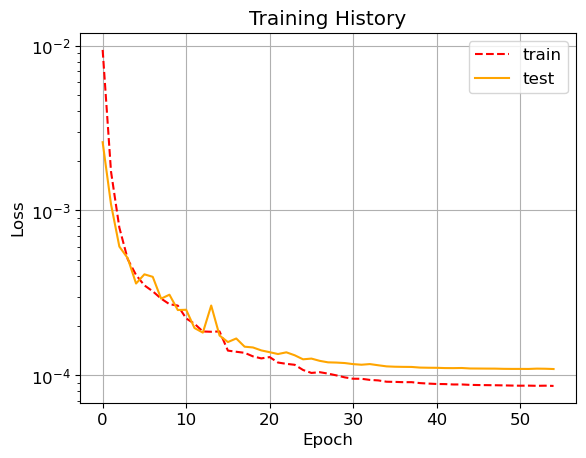

In [9]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


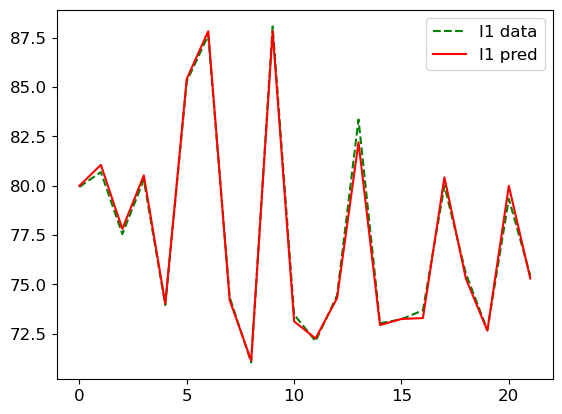

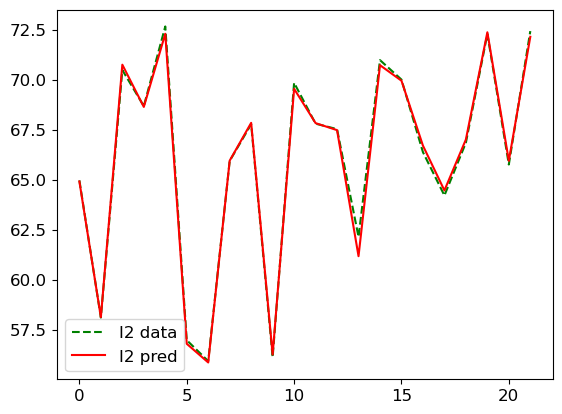

In [12]:
# Assume y_pr contains the normalized predictions and y_vl is the validation data
y_pr = best_model.predict(x_vl)

# Initialize arrays to store denormalized values
Y_pr = scaler_Y.inverse_transform(y_pr)
Y_vl = scaler_Y.inverse_transform(y_vl)

# Plot the results
plt.plot(Y_vl[:, 0], label='I1 data', c='g', ls='--')
plt.plot(Y_pr[:, 0], label='I1 pred', c='r')
plt.legend()
plt.show()

plt.plot(Y_vl[:, 1], label='I2 data', c='g', ls='--')
plt.plot(Y_pr[:, 1], label='I2 pred', c='r')
plt.legend()
plt.show()
